In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2022-01-03"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-29.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-30.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-31.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-01-01.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-01-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-01-03.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

In [4]:
df.head()

,Open,High,Low,Close,Volume
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262


## Adding TAs

#### Volatility Indicators

In [5]:
# #bbs: EITHER 0 or 1. Very bad
# # Add bollinger band high indicator filling nans values
# df["bb_high_indicator"] = ta.volatility.bollinger_hband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )
# # Add bollinger band low indicator filling nans values
# df["bb_low_indicator"] = ta.volatility.bollinger_lband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )

In [6]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [7]:
window = 30 # a choice
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# Relative Strength Index (RSI)
df["momentum_rsi"] = RSIIndicator(
    close=df["Close"], window=14, fillna=True
).rsi()/100 #scale 0-1

# Stoch RSI (StochRSI)
indicator_srsi = StochRSIIndicator(
    close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
)
df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

In [8]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629


#### Volume indicators
- Money Flow Index (MFI)
- Chaikin Money Flow (CMF)
- Force Index (FI)
- Volume Weighted Average Price (VWAP)
- ~Accumulation/Distribution Index (ADI)~
- ~On-Balance Volume (OBV)~
- ~Ease of Movement (EoM, EMV)~
- ~Volume-price Trend (VPT)~
- ~Negative Volume Index (NVI)~

In [9]:
# Chaikin Money Flow
df["volume_cmf"] = ChaikinMoneyFlowIndicator(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
).chaikin_money_flow()

# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).money_flow_index()

# Force Index
df["volume_fi"] = ForceIndexIndicator(
    close=df["Close"], volume=df["Volume"], window=13, fillna=True
).force_index()

# Volume Weighted Average Price
df["volume_vwap"] = VolumeWeightedAveragePrice(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
    window=14,
).volume_weighted_average_price()

In [10]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,50.000000,0.000000,46466.703333
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,-16.745680,46465.557715
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,-15.609408,46464.265572
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,-13.379492,46464.226297
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,-11.468854,46463.629546
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,3.138401,-9.830145,46463.404020
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,3.101163,-8.425954,46463.321194
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,3.101163,-7.222246,46462.959543
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,4.336658,-6.190371,46462.879979
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,4.319982,-5.306070,46462.856239


#### Trend indicators
- Simple Moving Average (SMA) (slow only)
- Exponential Moving Average (EMA) (slow only)
- Moving Average Convergence Divergence (MACD, signal, diff)

In [11]:
# MACD
indicator_macd = MACD(
    close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
)
df["trend_macd"] = indicator_macd.macd()
df["trend_macd_signal"] = indicator_macd.macd_signal()
df["trend_macd_diff"] = indicator_macd.macd_diff()

# SMAs
# df["trend_sma_fast"] = SMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).sma_indicator()
df["trend_sma_slow"] = SMAIndicator(
    close=df["Close"], window=26, fillna=True
).sma_indicator()

# EMAs
# df["trend_ema_fast"] = EMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).ema_indicator()
df["trend_ema_slow"] = EMAIndicator(
    close=df["Close"], window=26, fillna=True
).ema_indicator()

In [12]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,50.000000,0.000000,46466.703333,0.000000,0.000000,0.000000,46467.730000,46467.730000
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,-16.745680,46465.557715,-0.271225,-0.054245,-0.216980,46466.030000,46467.478148
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,-15.609408,46464.265572,-1.142741,-0.271944,-0.870797,46462.696667,46466.630137
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,-13.379492,46464.226297,-1.812529,-0.580061,-1.232468,46461.030000,46465.844942
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,-11.468854,46463.629546,-2.317435,-0.927536,-1.389899,46460.028000,46465.117168
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,3.138401,-9.830145,46463.404020,-2.685809,-1.279190,-1.406618,46459.361667,46464.444045
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,3.101163,-8.425954,46463.321194,-2.944611,-1.612275,-1.332336,46458.884286,46463.820041
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,3.101163,-7.222246,46462.959543,-3.113819,-1.912584,-1.201236,46458.526250,46463.242261
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,4.336658,-6.190371,46462.879979,-3.210107,-2.172088,-1.038019,46458.248889,46462.708019
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,4.319982,-5.306070,46462.856239,-3.249762,-2.387623,-0.862139,46458.026000,46462.212610


### use gen_feats0

In [13]:
df = gen_feats0(df)
df

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,...,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000,0.000000,0.000000,...,46466.703333,0.000000,0.000000,0.000000,46467.730000,46467.730000,3.08,0.00,0.01,3.07
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000,0.000000,0.000000,...,46465.557715,-0.271225,-0.054245,-0.216980,46466.030000,46467.478148,11.59,4.10,4.09,-3.40
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000,0.000000,0.000000,...,46464.265572,-1.142741,-0.271944,-0.870797,46462.696667,46466.630137,5.27,0.00,0.01,-5.26
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000,0.000000,0.000000,...,46464.226297,-1.812529,-0.580061,-1.232468,46461.030000,46465.844942,0.01,0.00,0.00,0.01
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000,0.000000,0.000000,...,46463.629546,-2.317435,-0.927536,-1.389899,46460.028000,46465.117168,0.01,0.01,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 23:59:55,46434.54,46434.54,46434.53,46434.54,0.02350,0.045030,0.617375,0.870016,0.801845,0.629369,...,46421.927988,1.404085,0.174217,1.229868,46422.562308,46423.912984,0.01,0.00,0.01,0.00
2022-01-03 23:59:56,46434.53,46435.87,46434.53,46435.87,0.15848,0.058718,0.628269,0.902504,0.880846,0.773522,...,46422.269518,2.141908,0.567756,1.574153,46423.196154,46424.798689,1.34,0.00,0.00,1.34
2022-01-03 23:59:57,46435.87,46446.09,46435.87,46446.09,1.41460,0.069936,0.699147,1.000000,0.924174,0.868955,...,46426.124202,3.510836,1.156372,2.354465,46424.223077,46426.375823,10.22,0.00,0.00,10.22
2022-01-03 23:59:58,46446.09,46446.10,46446.09,46446.10,0.21627,0.057541,0.699208,1.000000,0.967501,0.924174,...,46426.383198,4.544146,1.833927,2.710220,46425.250385,46427.836873,0.01,0.00,0.00,0.01


## Drop OHL, stationize C, and related

In [14]:
def stationize(series):
    return np.log(series / series.shift(1))

In [15]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
df['log_ret'] = stationize(df['Close'])
df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [16]:
df.drop(["Open","High","Low"], axis=1, inplace=True)

In [17]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [18]:
HORIZON = 1
WINDOW = 30

In [19]:
# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  df[f"Price+{i+1}"] = df["Close"].shift(periods=i+1)
df.head(50)

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
2021-12-30 00:00:00,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,50.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:01,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:03,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:04,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:05,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,3.138401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:06,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,3.101163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:07,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,3.101163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:08,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,4.336658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:09,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,4.319982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.dropna().shape

(431970, 55)

In [21]:
df.shape

(432000, 55)

In [22]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1).astype(np.float32) 
X.head()

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
2021-12-30 00:00:30,0.33023,0.050766,0.720308,0.574519,0.670028,0.792579,0.232797,0.403595,84.226425,2.991016,...,46456.019531,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.031250,46456.031250,46464.328125,46467.730469
2021-12-30 00:00:31,0.50273,0.058066,0.720075,0.573890,0.558384,0.669943,0.238554,0.357872,84.899857,2.563010,...,46456.019531,46456.019531,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.031250,46456.031250,46464.328125
2021-12-30 00:00:32,0.16562,0.075964,0.720172,0.411394,0.519934,0.582782,0.243305,0.364759,83.616508,2.197102,...,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.031250,46456.031250
2021-12-30 00:00:33,0.16494,0.076158,0.721114,0.105548,0.363611,0.480643,0.247545,0.432144,83.098122,1.885351,...,46456.031250,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.031250
2021-12-30 00:00:34,0.29916,0.078461,0.732532,0.170661,0.229201,0.370915,0.254549,0.408268,65.648994,1.661316,...,46450.390625,46456.031250,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531,46456.019531,46456.031250,46456.019531


In [23]:
y = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1)["log_ret"].astype(np.float32)
y.head()

2021-12-30 00:00:30    4.258950e-05
2021-12-30 00:00:31   -2.150939e-07
2021-12-30 00:00:32    2.150939e-07
2021-12-30 00:00:33    1.935843e-06
2021-12-30 00:00:34    2.279965e-05
Freq: S, Name: log_ret, dtype: float32

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [24]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(259182, 259182, 86394, 86394, 86394, 86394)

## Model building and fitting

In [25]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

# Fit
history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=10, #saw that 20 was good enough
                                       batch_size=128,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

2022-02-04 18:18:22.483802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-04 18:18:22.483928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-04 18:18:22.617690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro
Epoch 1/10
  10/2025 [..............................] - ETA: 11s - loss: 22861.8691 - mse: 874552768.0000 - mape: 10138470580224.0000 - mae: 22861.8691  

2022-02-04 18:18:22.771701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2024/2025 [============================>.] - ETA: 0s - loss: 360.6863 - mse: 4653311.0000 - mape: 159299616768.0000 - mae: 360.6863

2022-02-04 18:18:34.160086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
2025/2025 [==============================] - 14s 7ms/step - loss: 360.5401 - mse: 4651336.0000 - mape: 159235293184.0000 - mae: 360.5401 - val_loss: 8.0627 - val_mse: 65.0913 - val_mape: 3858332416.0000 - val_mae: 8.0627
Epoch 2/10
   1/2025 [..............................] - ETA: 29s - loss: 8.0272 - mse: 64.5566 - mape: 3532401408.0000 - mae: 8.0272

2022-02-04 18:18:36.013405: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2025/2025 [==============================] - 13s 6ms/step - loss: 11.6299 - mse: 382.6745 - mape: 5105160704.0000 - mae: 11.6299 - val_loss: 2.9233 - val_mse: 8.5459 - val_mape: 1397445120.0000 - val_mae: 2.9233
Epoch 3/10
2025/2025 [==============================] - 14s 7ms/step - loss: 0.6433 - mse: 11.2105 - mape: 281016096.0000 - mae: 0.6433 - val_loss: 6.2640e-04 - val_mse: 3.9825e-07 - val_mape: 299280.8125 - val_mae: 6.2640e-04
Epoch 4/10
2025/2025 [==============================] - 15s 7ms/step - loss: 3.9077e-04 - mse: 1.7955e-07 - mape: 169957.7500 - mae: 3.9077e-04 - val_loss: 2.7938e-04 - val_mse: 8.3165e-08 - val_mape: 132684.8125 - val_mae: 2.7938e-04
Epoch 5/10
2025/2025 [==============================] - 16s 8ms/step - loss: 4.3620e-04 - mse: 2.3041e-07 - mape: 190187.4844 - mae: 4.3620e-04 - val_loss: 3.9446e-04 - val_mse: 1.6107e-07 - val_mape: 188070.3438 - val_mae: 3.9446e-04
Epoch 6/10
2025/2025 [==============================] - 14s 7ms/step - loss: 3.5531e-04 - m

## Examining Histories

In [26]:
import matplotlib.pyplot as plt

In [27]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


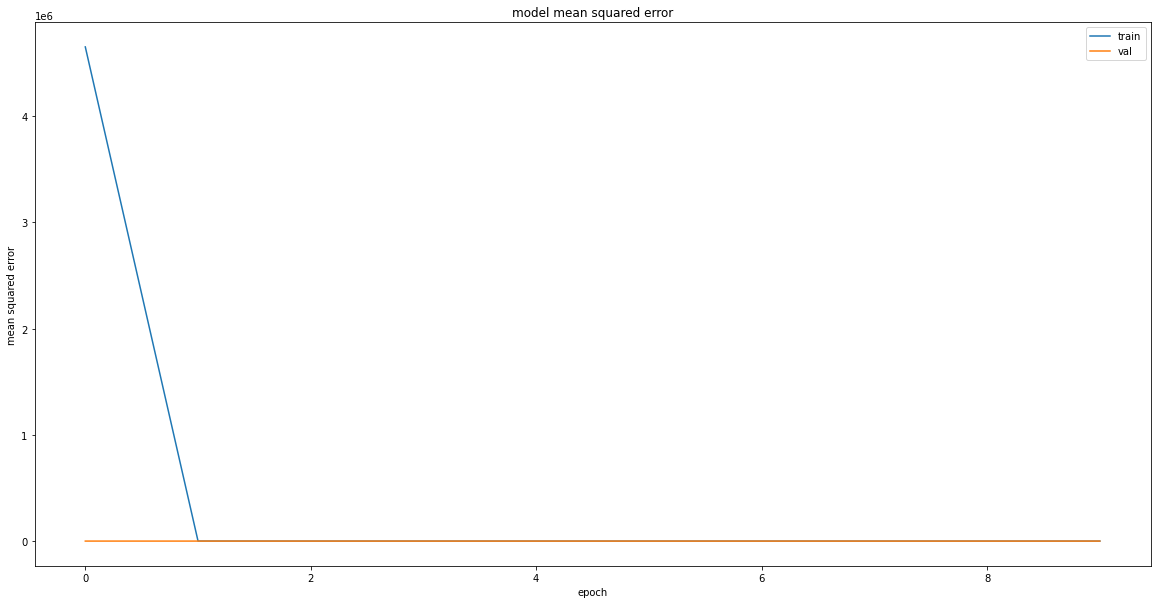

In [28]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

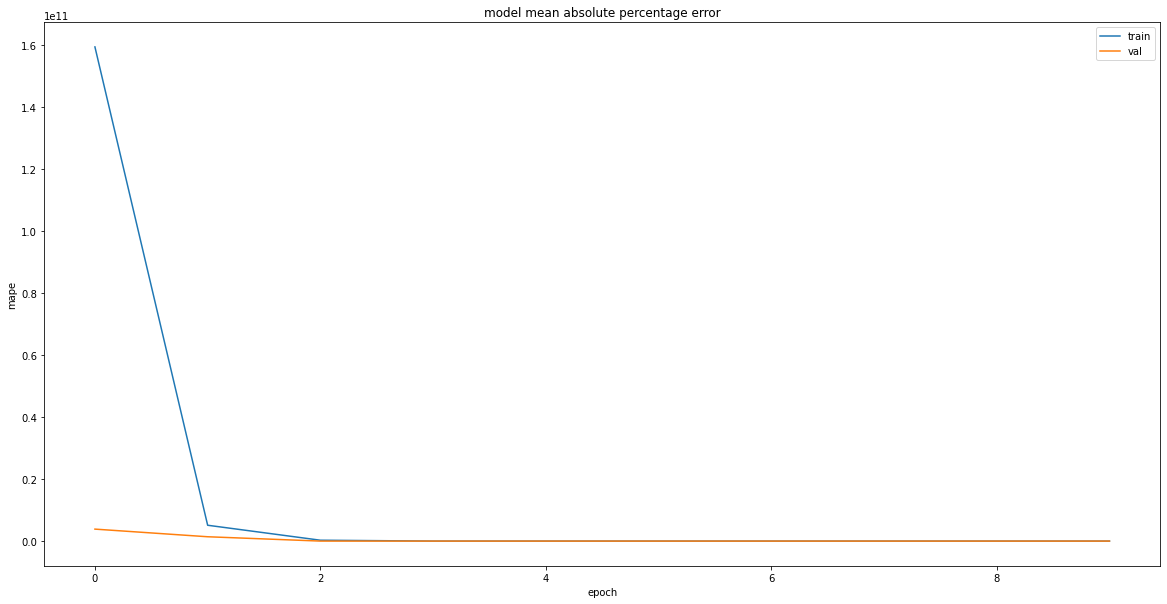

In [29]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [30]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
loss = model_6.evaluate(X_test, y_test)

  24/2700 [..............................] - ETA: 11s - loss: 2.2269e-04 - mse: 5.5050e-08 - mape: 86247.0781 - mae: 2.2269e-04 

2022-02-04 18:20:43.401222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2700/2700 [==============================] - 13s 5ms/step - loss: 2.1886e-04 - mse: 5.3606e-08 - mape: 92880.0000 - mae: 2.1886e-04


In [31]:
# percentage
y_pred = model_6.predict(X_test)

2022-02-04 18:20:56.269149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [32]:
type(y_pred)

numpy.ndarray

In [33]:
y_test = np.array(y_test)

In [34]:
type(y_test)

numpy.ndarray

In [35]:
y_test

array([ 0.0000000e+00,  2.1147427e-07, -2.1147427e-07, ...,
        2.2006426e-04,  2.1530336e-07,  0.0000000e+00], dtype=float32)

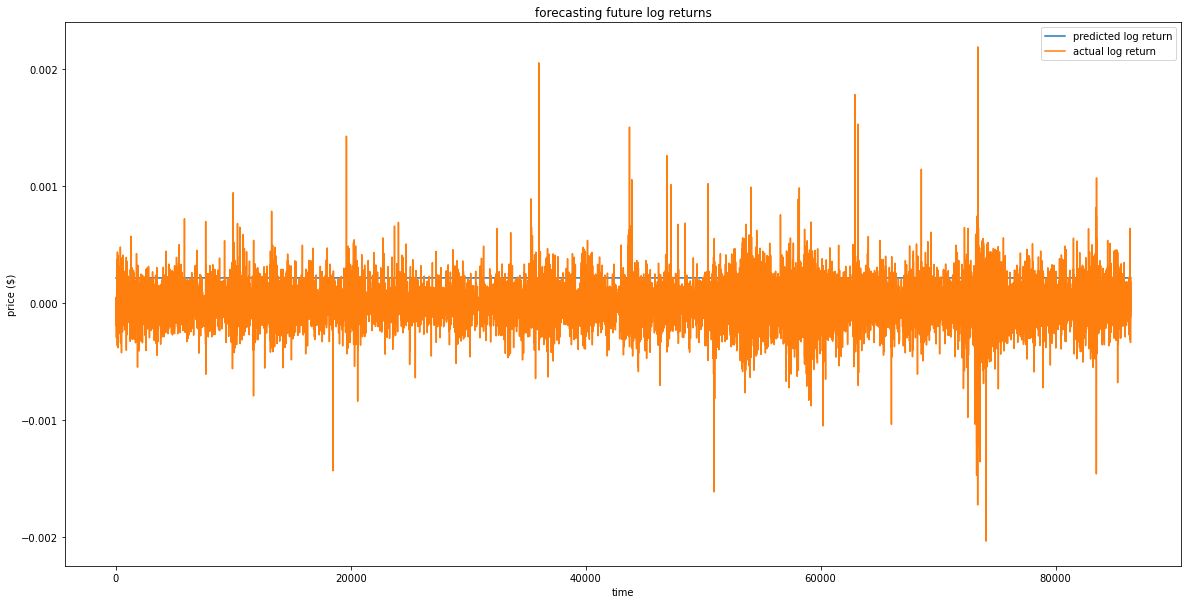

In [36]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

In [37]:
X_test

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
2022-01-03 00:00:06,0.23669,-0.050073,0.339584,1.000000,1.000000,0.884838,-0.412552,0.379201,96.660103,0.132211,...,47292.679688,47310.988281,47310.988281,47310.160156,47306.589844,47306.589844,47306.601562,47311.000000,47311.000000,47310.761719
2022-01-03 00:00:07,0.24158,-0.050559,0.339991,1.000000,1.000000,0.961684,-0.400749,0.631838,96.874336,0.113669,...,47292.378906,47292.679688,47310.988281,47310.988281,47310.160156,47306.589844,47306.589844,47306.601562,47311.000000,47311.000000
2022-01-03 00:00:08,0.59497,-0.050580,0.339766,0.998098,0.999366,0.999789,-0.390767,0.559222,83.639740,0.096581,...,47286.171875,47292.378906,47292.679688,47310.988281,47310.988281,47310.160156,47306.589844,47306.589844,47306.601562,47311.000000
2022-01-03 00:00:09,0.01160,-0.041263,0.340236,1.000000,0.999366,0.999577,-0.382086,0.560492,83.710617,0.082800,...,47286.160156,47286.171875,47292.378906,47292.679688,47310.988281,47310.988281,47310.160156,47306.589844,47306.589844,47306.601562
2022-01-03 00:00:10,0.21407,-0.041263,0.339975,0.997800,0.998632,0.999121,-0.374632,0.494738,79.797409,0.070666,...,47286.171875,47286.160156,47286.171875,47292.378906,47292.679688,47310.988281,47310.988281,47310.160156,47306.589844,47306.589844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 23:59:55,0.02350,0.045030,0.617375,0.870016,0.801845,0.629369,0.066180,0.425363,71.730011,1.646442,...,46419.390625,46417.539062,46419.390625,46419.390625,46419.390625,46419.398438,46419.390625,46413.628906,46408.621094,46413.640625
2022-01-03 23:59:56,0.15848,0.058718,0.628269,0.902504,0.880846,0.773522,0.099285,0.424598,71.277008,1.441347,...,46419.390625,46419.390625,46417.539062,46419.390625,46419.390625,46419.390625,46419.398438,46419.390625,46413.628906,46408.621094
2022-01-03 23:59:57,1.41460,0.069936,0.699147,1.000000,0.924174,0.868955,0.156214,0.545131,76.526550,3.300756,...,46422.718750,46419.390625,46419.390625,46417.539062,46419.390625,46419.390625,46419.390625,46419.398438,46419.390625,46413.628906
2022-01-03 23:59:58,0.21627,0.057541,0.699208,1.000000,0.967501,0.924174,0.198439,0.541329,76.077850,2.829529,...,46419.359375,46422.718750,46419.390625,46419.390625,46417.539062,46419.390625,46419.390625,46419.390625,46419.398438,46419.390625
